In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from featurisation import process_dataframe
from analysis import analysis_stratification_influence, analysis_train_set_size

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('data_csv/Data_test10252021.csv')

In [4]:
X, y, DOIs, mechanisms, origins = process_dataframe(df)

In [5]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = r2_score

# 1. Yields distribution by origin and mechanism

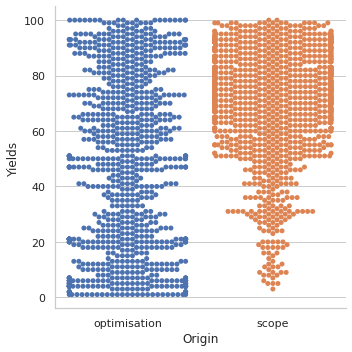

In [11]:
# basic analysis of yields by origin and mechanism
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

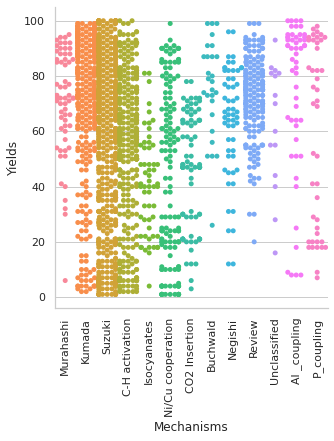

In [14]:
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [15]:
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=1)

In [16]:
metric_mean = np.mean(metric_values, axis=1)
metric_lower = np.percentile(metric_values, 5, axis=1)
metric_upper = np.percentile(metric_values, 95, axis=1)

baseline_mean = np.mean(baseline_values, axis=1)
baseline_lower = np.percentile(baseline_values, 5, axis=1)
baseline_upper = np.percentile(baseline_values, 95, axis=1)

# 2. Evolution of performance with training data availibility

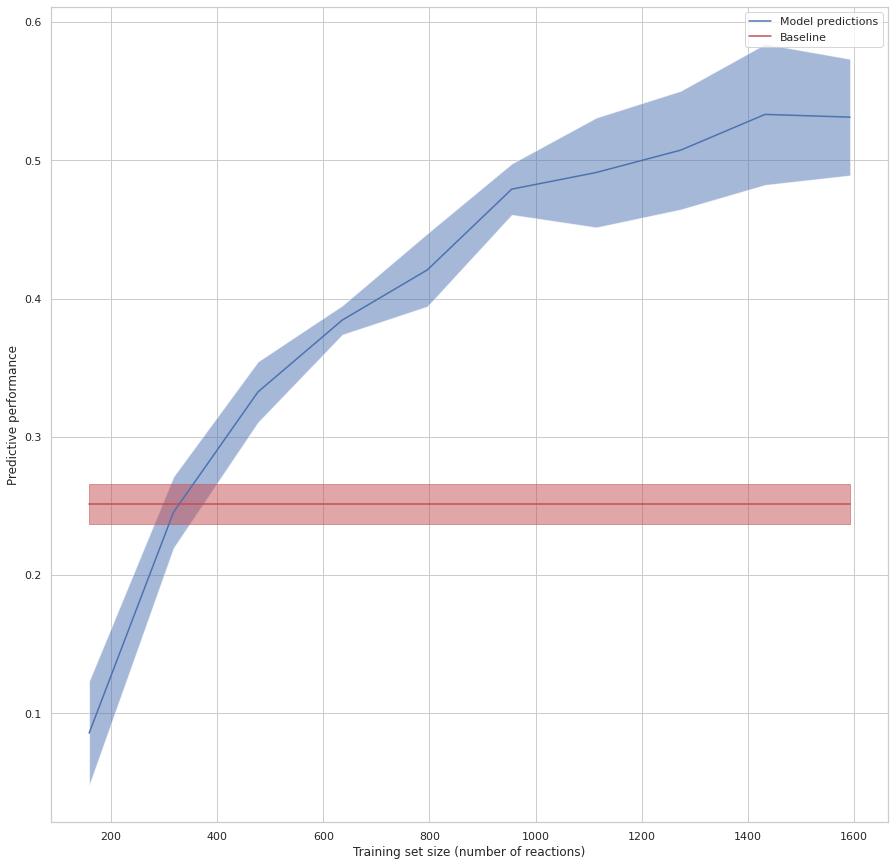

In [17]:
plt.figure(figsize=(15, 15))
plt.plot(sizes, metric_mean, label='Model predictions')
plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

plt.plot(sizes, baseline_mean, c='r', label='Baseline')
plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

plt.xlabel("Training set size (number of reactions)")
plt.ylabel("Predictive performance")

plt.legend()
plt.show()

In [19]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, DOIs, metric=metric, predictor = pipe, test_size=0.2, n_iterations=3)

In [22]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


In [31]:
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

# 3. Increase of performance compared to baseline, by DOI

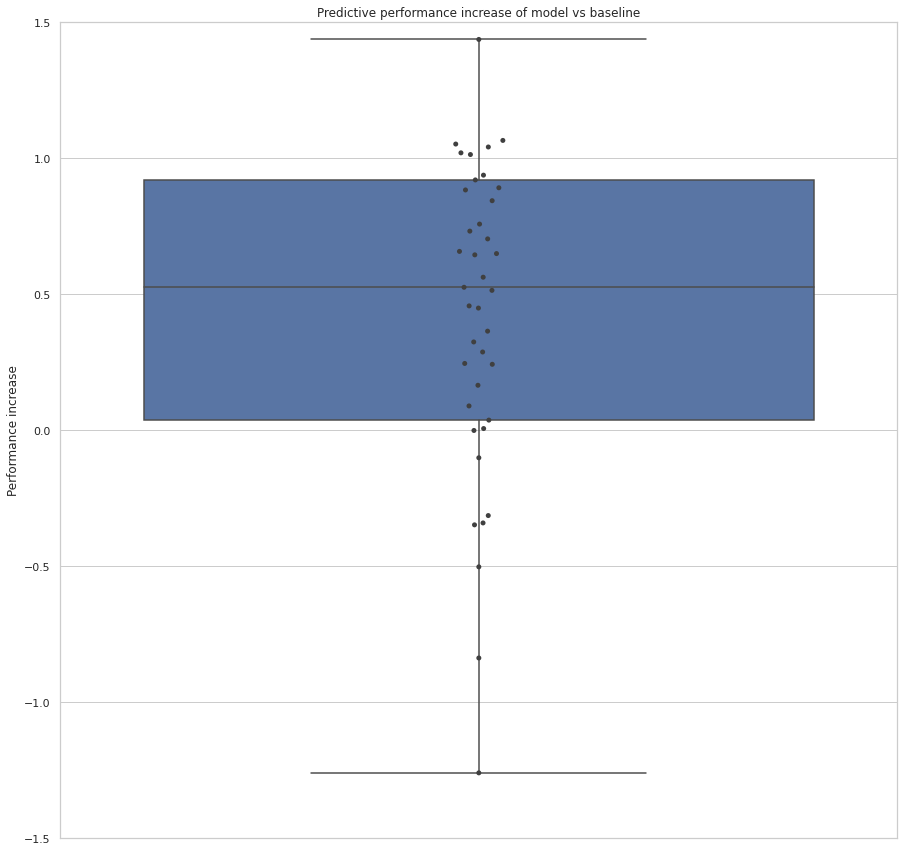

In [24]:
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(metric_augmented-metric_baseline_standalone, columns =['Performance increase'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-1.5, 1.5)
#plt.boxplot(metric_augmented-metric_baseline_standalone)
plt.show()

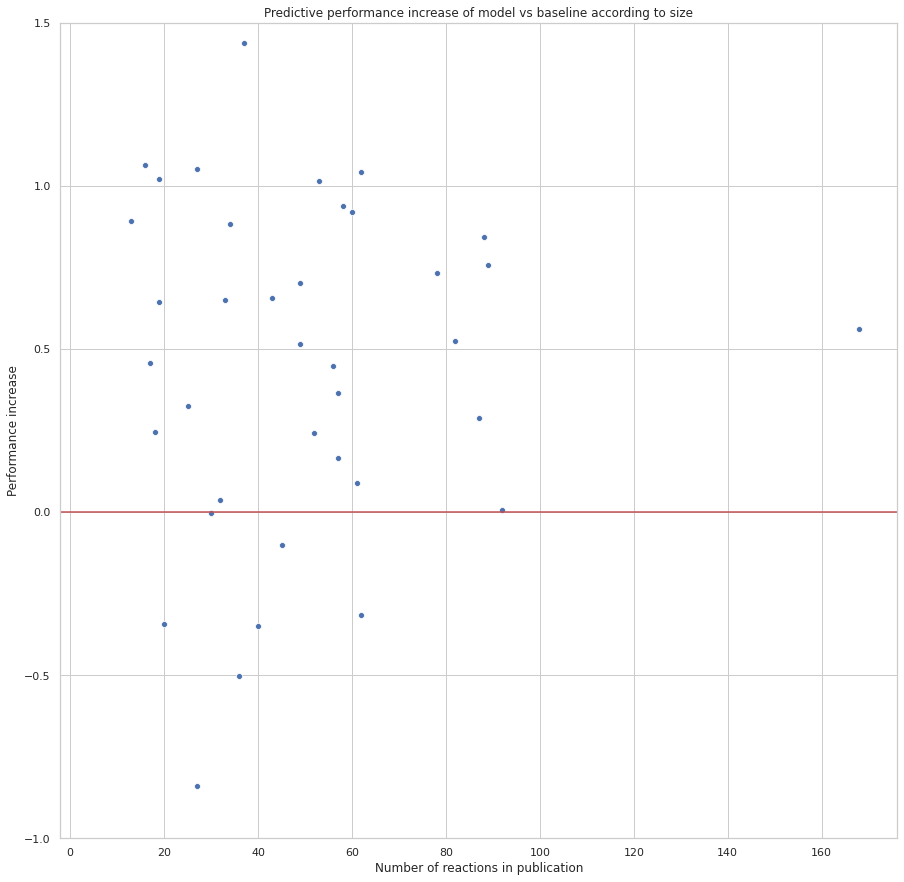

In [32]:
plt.figure(figsize=(15, 15))

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_baseline_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of model vs baseline according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

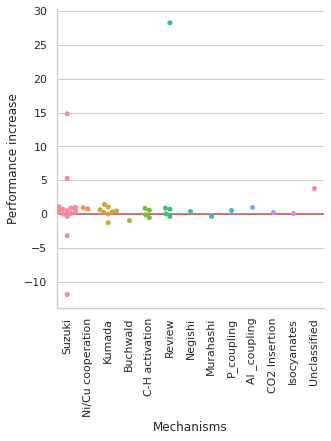

In [46]:
chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

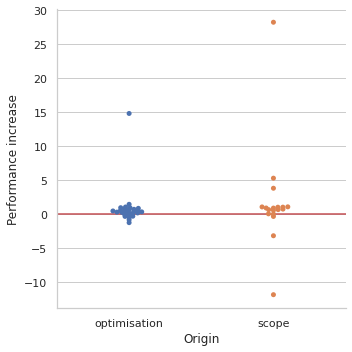

In [47]:
chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")

plt.axhline(0, c='r')
plt.show()

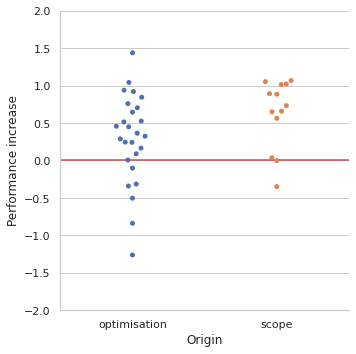

In [48]:
chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.ylim(-2, 2)
plt.axhline(0, c='r')
plt.show()

# 4. Increase of performance compared to local model, by DOI

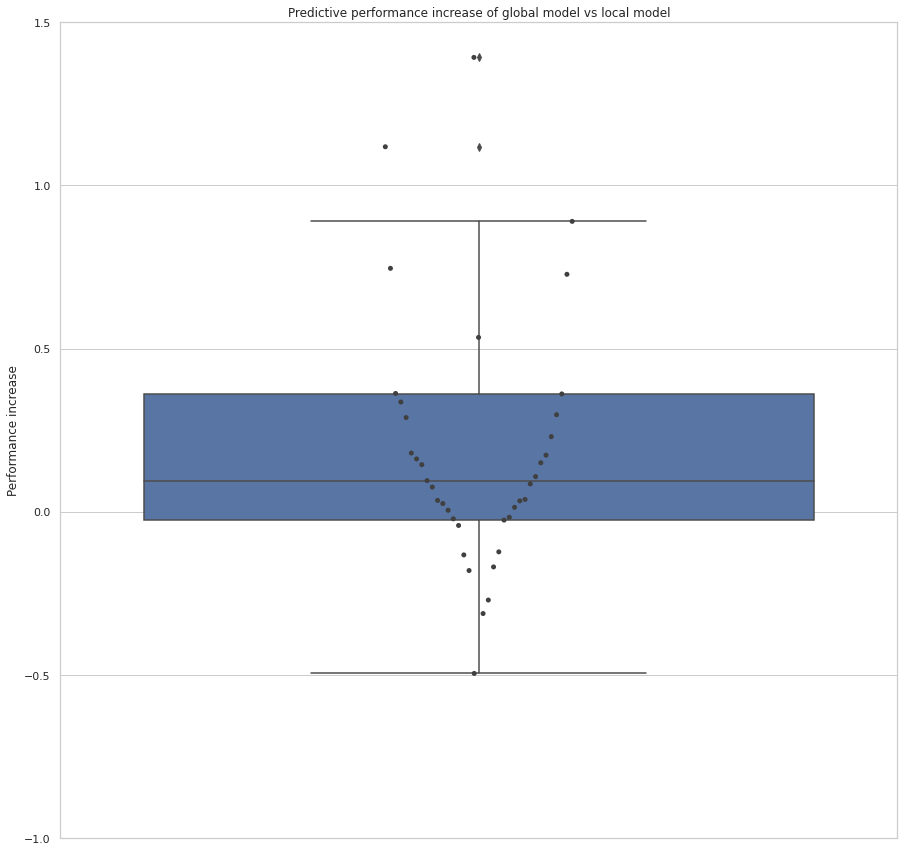

In [51]:
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of global model vs local model")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-1, 1.5)

plt.show()

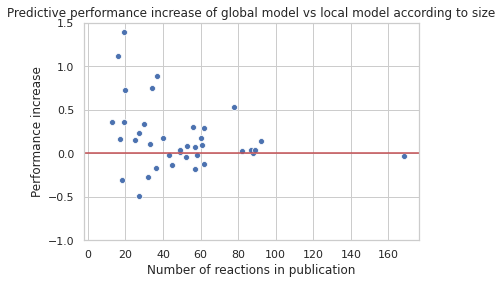

In [52]:
plt.title("Predictive performance increase of global model vs local model according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

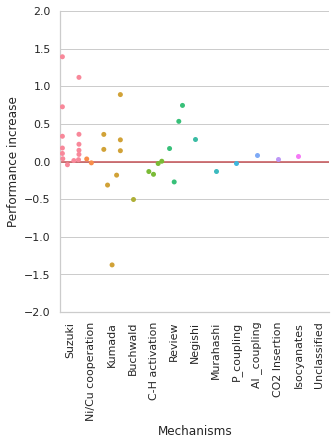

In [54]:
chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()

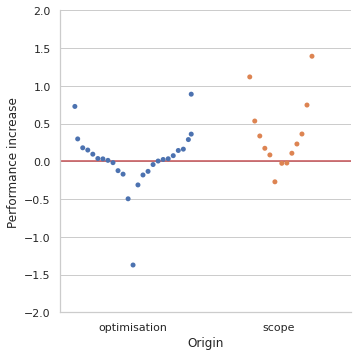

In [57]:
chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.ylim(-2, 2)
plt.axhline(0, c='r')
plt.show()

In [63]:
metric_standalone

array([[  0.0426757 ],
       [  0.0662654 ],
       [  0.68091997],
       [  0.46893966],
       [ -0.59507147],
       [  0.06851196],
       [ -0.26999498],
       [  0.29166611],
       [  0.84570421],
       [  0.69244574],
       [  0.15728043],
       [  0.44628656],
       [-25.83161071]])

In [66]:
metric_augmented

array([[  0.28413356],
       [ -0.05307435],
       [  0.67309807],
       [  0.42020119],
       [ -0.45307382],
       [  0.02826795],
       [ -0.32272685],
       [  0.76667524],
       [  0.85496808],
       [  0.53116632],
       [  0.38439366],
       [  0.43355433],
       [-21.44100485]])

In [64]:
np.median(metric_standalone)

0.15728042837532275

In [65]:
np.median(metric_augmented)

0.38439365948764337

# 5. What happens if we stratify by mechanism?

In [58]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=1)

In [67]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


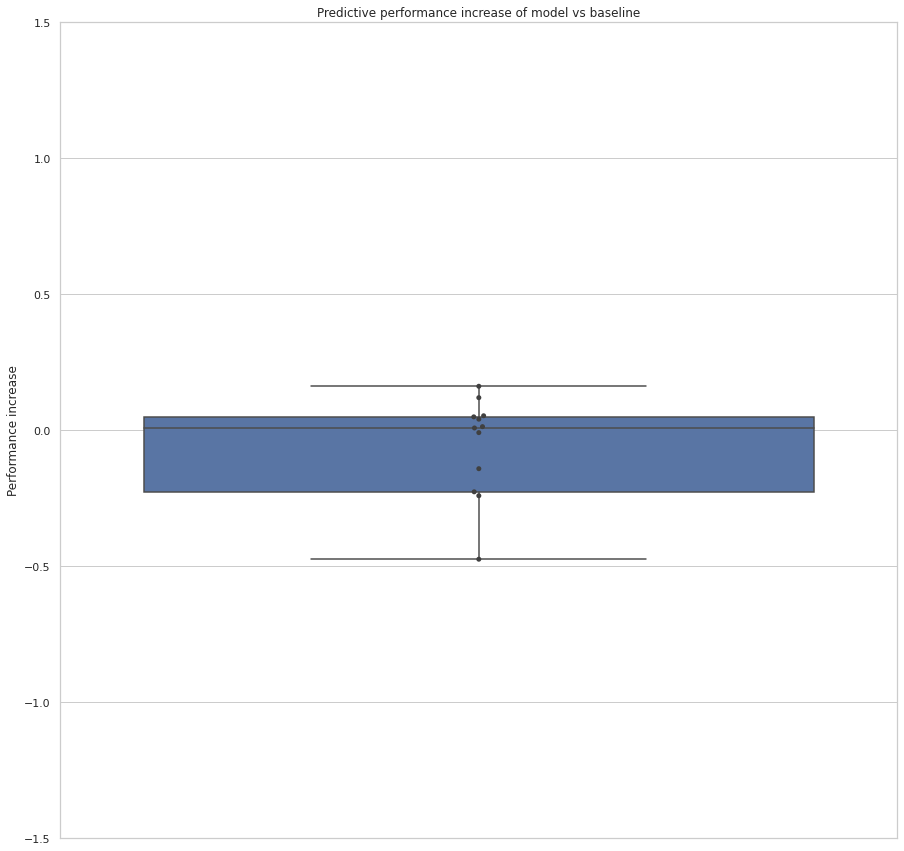

In [75]:
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip(metric_standalone-metric_augmented, unique_stratification), columns =['Performance increase', 'Mechanism'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-1.5, 1.5)
#plt.boxplot(metric_augmented-metric_baseline_standalone)
plt.show()

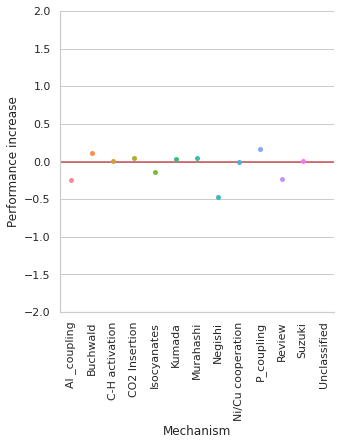

In [76]:
chart = sns.catplot(x="Mechanism", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()